# TFG

Primero importamos las librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sea

In [2]:
from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster


Importamos los datos, e imprimimos los primeros para comprobar que se han importado correctamente.

In [3]:
df = pd.read_csv('BTC-Daily.csv')
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43185.48,49.006289,2.116360e+06
1,1646006400,2022-02-28 00:00:00,BTC/USD,37717.10,44256.08,37468.99,43178.98,3160.618070,1.364723e+08
2,1645920000,2022-02-27 00:00:00,BTC/USD,39146.66,39886.92,37015.74,37712.68,1701.817043,6.418008e+07
3,1645833600,2022-02-26 00:00:00,BTC/USD,39242.64,40330.99,38600.00,39146.66,912.724087,3.573010e+07
4,1645747200,2022-02-25 00:00:00,BTC/USD,38360.93,39727.97,38027.61,39231.64,2202.851827,8.642149e+07


In [4]:
df.tail()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
2646,1417478400,2014-12-02 00:00:00,BTC/USD,378.39,382.86,375.23,379.25,2593576.46,6832.53
2647,1417392000,2014-12-01 00:00:00,BTC/USD,376.40,382.31,373.03,378.39,2520662.37,6660.56
2648,1417305600,2014-11-30 00:00:00,BTC/USD,376.57,381.99,373.32,373.34,1145566.61,3046.33
2649,1417219200,2014-11-29 00:00:00,BTC/USD,376.42,386.60,372.25,376.72,2746157.05,7245.19
2650,1417132800,2014-11-28 00:00:00,BTC/USD,363.59,381.34,360.57,376.28,3220878.18,8617.15


Observamos el número de valores de cada columna y que no tengan ningún valor nulo

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2651 entries, 0 to 2650
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   unix        2651 non-null   int64  
 1   date        2651 non-null   object 
 2   symbol      2651 non-null   object 
 3   open        2651 non-null   float64
 4   high        2651 non-null   float64
 5   low         2651 non-null   float64
 6   close       2651 non-null   float64
 7   Volume BTC  2651 non-null   float64
 8   Volume USD  2651 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 186.5+ KB
None


Visulaizamos las estadísticas de los datos

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unix,2651.0,1.531613e+09,6.613247e+07,1.417133e+09,1.474373e+09,1.531613e+09,1.588853e+09,1.646093e+09
open,2651.0,1.169319e+04,1.627255e+04,1.620000e+02,6.546800e+02,6.408950e+03,1.070862e+04,6.754749e+04
high,2651.0,1.203856e+04,1.673924e+04,2.128400e+02,6.644600e+02,6.540000e+03,1.095624e+04,6.900000e+04
low,2651.0,1.129654e+04,1.571830e+04,1.524000e+02,6.400500e+02,6.312000e+03,1.030376e+04,6.625000e+04
close,2651.0,1.170933e+04,1.628291e+04,1.620000e+02,6.543700e+02,6.407770e+03,1.072642e+04,6.755900e+04
Volume BTC,2651.0,1.330041e+07,4.715366e+07,0.000000e+00,5.357883e+03,1.503310e+04,3.435336e+06,7.723295e+08
Volume USD,2651.0,6.099369e+07,1.072838e+08,0.000000e+00,9.516170e+03,2.288982e+07,8.018383e+07,1.446125e+09


Visulaizamos los precios de 'open' en un histograma

array([[<Axes: title={'center': 'open'}>]], dtype=object)

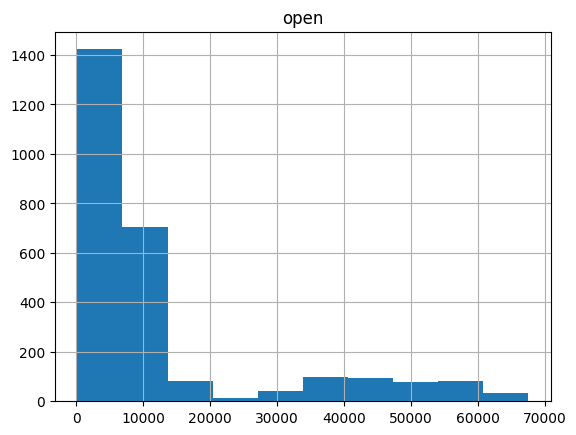

In [7]:
df.hist('open')

Eliminamos las columnas unix, symbol y Volume BTC que no van a ser útiles de cara al entrenamiento, esto lo hacemos en una copia de df que se llamará df_sn y es lo que utilizaremos a partir de ahora.

In [8]:
#df_sn = solo los datos necesarios para entrenar el algoritmo, con tiempo aún de reducirlos más
df_sn = df.copy().drop(['unix', 'symbol', 'Volume BTC'], axis = 1)
df_sn.sort_values(by='date')

,date,open,high,low,close,Volume USD
2650,2014-11-28 00:00:00,363.59,381.34,360.57,376.28,8.617150e+03
2649,2014-11-29 00:00:00,376.42,386.60,372.25,376.72,7.245190e+03
2648,2014-11-30 00:00:00,376.57,381.99,373.32,373.34,3.046330e+03
2647,2014-12-01 00:00:00,376.40,382.31,373.03,378.39,6.660560e+03
2646,2014-12-02 00:00:00,378.39,382.86,375.23,379.25,6.832530e+03
...,...,...,...,...,...,...
4,2022-02-25 00:00:00,38360.93,39727.97,38027.61,39231.64,8.642149e+07
3,2022-02-26 00:00:00,39242.64,40330.99,38600.00,39146.66,3.573010e+07
2,2022-02-27 00:00:00,39146.66,39886.92,37015.74,37712.68,6.418008e+07
1,2022-02-28 00:00:00,37717.10,44256.08,37468.99,43178.98,1.364723e+08


# Preprocesado de datos

Obtenemos en una variable la cantidad de filas 

In [9]:
tamanio = df_sn.shape[0]
tamanio

2651

Separamos el 10% de los datos con fecha más reciente para test

In [10]:
df_test = df_sn.copy().loc[0:int(tamanio*0.1)]
df_test

,date,open,high,low,close,Volume USD
0,2022-03-01 00:00:00,43221.71,43626.49,43185.48,43185.48,2.116360e+06
1,2022-02-28 00:00:00,37717.10,44256.08,37468.99,43178.98,1.364723e+08
2,2022-02-27 00:00:00,39146.66,39886.92,37015.74,37712.68,6.418008e+07
3,2022-02-26 00:00:00,39242.64,40330.99,38600.00,39146.66,3.573010e+07
4,2022-02-25 00:00:00,38360.93,39727.97,38027.61,39231.64,8.642149e+07
...,...,...,...,...,...,...
261,2021-06-13 00:00:00,35563.66,39386.43,34783.90,39013.76,1.405244e+08
262,2021-06-12 00:00:00,37338.91,37445.55,34630.00,35542.76,1.325017e+08
263,2021-06-11 00:00:00,36724.97,37680.65,35958.49,37341.11,1.397017e+08
264,2021-06-10 00:00:00,37414.64,38446.24,35824.69,36707.54,2.114987e+08


Separamos un 20% de los datos para validación

In [11]:
df_vali = df_sn.copy().loc[range(int(tamanio*0.1)+1, int(tamanio*0.3))]
df_vali

,date,open,high,low,close,Volume USD
266,2021-06-08 00:00:00,33567.51,34085.61,31025.00,33411.69,3.021970e+08
267,2021-06-07 00:00:00,35810.69,36808.30,33321.09,33582.62,1.649928e+08
268,2021-06-06 00:00:00,35532.59,36510.58,35250.00,35808.85,9.047943e+07
269,2021-06-05 00:00:00,36851.58,37927.93,34849.65,35532.14,1.459074e+08
270,2021-06-04 00:00:00,39242.94,39277.36,35576.67,36887.32,2.134369e+08
...,...,...,...,...,...,...
790,2020-01-01 00:00:00,7160.69,7237.35,7150.00,7178.68,8.033730e+06
791,2019-12-31 00:00:00,7222.74,7302.35,7112.55,7168.36,1.891509e+07
792,2019-12-30 00:00:00,7372.79,7384.90,7199.00,7220.24,2.688033e+07
793,2019-12-29 00:00:00,7297.43,7524.46,7274.43,7385.54,1.908314e+07


Separamos para entrenamiento el 70% de los datos, empezando por los que tienen la fecha inicial más temprana

In [12]:
df_train = df_sn.copy().loc[range(int(tamanio*0.3), tamanio)]
df_train

,date,open,high,low,close,Volume USD
795,2019-12-27 00:00:00,7195.17,7255.37,7052.00,7246.00,2.916204e+07
796,2019-12-26 00:00:00,7195.80,7432.00,7150.00,7188.30,2.240411e+07
797,2019-12-25 00:00:00,7247.45,7266.81,7110.73,7195.79,1.082626e+07
798,2019-12-24 00:00:00,7317.47,7431.10,7156.00,7251.52,3.041715e+07
799,2019-12-23 00:00:00,7521.88,7692.98,7247.86,7316.17,4.909711e+07
...,...,...,...,...,...,...
2646,2014-12-02 00:00:00,378.39,382.86,375.23,379.25,6.832530e+03
2647,2014-12-01 00:00:00,376.40,382.31,373.03,378.39,6.660560e+03
2648,2014-11-30 00:00:00,376.57,381.99,373.32,373.34,3.046330e+03
2649,2014-11-29 00:00:00,376.42,386.60,372.25,376.72,7.245190e+03


Indexamos el conjunto de test por 'date' y lo ordenamos.

In [13]:
df_test = df_test.set_index('date')
df_test = df_test.sort_index()
df_test

,open,high,low,close,Volume USD
date,,,,,
2021-06-09 00:00:00,33413.19,37556.25,32423.72,37400.00,3.193806e+08
2021-06-10 00:00:00,37414.64,38446.24,35824.69,36707.54,2.114987e+08
2021-06-11 00:00:00,36724.97,37680.65,35958.49,37341.11,1.397017e+08
2021-06-12 00:00:00,37338.91,37445.55,34630.00,35542.76,1.325017e+08
2021-06-13 00:00:00,35563.66,39386.43,34783.90,39013.76,1.405244e+08
...,...,...,...,...,...
2022-02-25 00:00:00,38360.93,39727.97,38027.61,39231.64,8.642149e+07
2022-02-26 00:00:00,39242.64,40330.99,38600.00,39146.66,3.573010e+07
2022-02-27 00:00:00,39146.66,39886.92,37015.74,37712.68,6.418008e+07


Indexamos el conjunto de validación por 'date' y lo ordenamos.

In [14]:
df_vali = df_vali.set_index('date')
df_vali = df_vali.sort_index()
df_vali

,open,high,low,close,Volume USD
date,,,,,
2019-12-28 00:00:00,7247.70,7349.65,7231.00,7296.24,1.152589e+07
2019-12-29 00:00:00,7297.43,7524.46,7274.43,7385.54,1.908314e+07
2019-12-30 00:00:00,7372.79,7384.90,7199.00,7220.24,2.688033e+07
2019-12-31 00:00:00,7222.74,7302.35,7112.55,7168.36,1.891509e+07
2020-01-01 00:00:00,7160.69,7237.35,7150.00,7178.68,8.033730e+06
...,...,...,...,...,...
2021-06-04 00:00:00,39242.94,39277.36,35576.67,36887.32,2.134369e+08
2021-06-05 00:00:00,36851.58,37927.93,34849.65,35532.14,1.459074e+08
2021-06-06 00:00:00,35532.59,36510.58,35250.00,35808.85,9.047943e+07


Indexamos el conjunto de entrenamiento por 'date' y lo ordenamos.

In [15]:
#df_train = df_train.set_index('date')
#df_train = df_train.sort_index()
df_train

,date,open,high,low,close,Volume USD
795,2019-12-27 00:00:00,7195.17,7255.37,7052.00,7246.00,2.916204e+07
796,2019-12-26 00:00:00,7195.80,7432.00,7150.00,7188.30,2.240411e+07
797,2019-12-25 00:00:00,7247.45,7266.81,7110.73,7195.79,1.082626e+07
798,2019-12-24 00:00:00,7317.47,7431.10,7156.00,7251.52,3.041715e+07
799,2019-12-23 00:00:00,7521.88,7692.98,7247.86,7316.17,4.909711e+07
...,...,...,...,...,...,...
2646,2014-12-02 00:00:00,378.39,382.86,375.23,379.25,6.832530e+03
2647,2014-12-01 00:00:00,376.40,382.31,373.03,378.39,6.660560e+03
2648,2014-11-30 00:00:00,376.57,381.99,373.32,373.34,3.046330e+03
2649,2014-11-29 00:00:00,376.42,386.60,372.25,376.72,7.245190e+03


In [16]:
forecaster = ForecasterAutoreg(
    regressor = LGBMRegressor(max_depth=4, learning_rate=0.1, n_estimators=50),
    lags = [1, 2, 3, 4, 5, 6, 7],
)

In [17]:
forecaster.fit(y=df_train['open'])
forecaster

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1849, number of used features: 7
[LightGBM] [Info] Start training from score 3848.003274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

C:\Users\raulg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\skforecast\utils\utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\raulg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\skforecast\utils\utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=4, n_estimators=50) 
Lags: [1 2 3 4 5 6 7] 
Transformer for y: None 
Transformer for exog: None 
Window size: 7 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [0, 1855] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 4, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 50, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
fit_kwargs: {} 
Creation date: 2024-09-30 15:01:11 
Last fit date: 2024-09-30 15:01:11 
Skforecast version: 0.13.0 
Python version: 3.10.11 
Forecaster id: None 

In [18]:
prediccion = forecaster.predict(steps=24)
prediccion

C:\Users\raulg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\skforecast\utils\utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


7     388.726979
8     406.834770
9     406.834770
10    406.834770
11    406.834770
12    406.834770
13    406.834770
14    406.834770
15    406.834770
16    406.834770
17    406.834770
18    406.834770
19    406.834770
20    406.834770
21    406.834770
22    406.834770
23    406.834770
24    406.834770
25    406.834770
26    406.834770
27    406.834770
28    406.834770
29    406.834770
30    406.834770
Name: pred, dtype: float64

In [19]:
from pycaret.internal.pycaret_experiment import TimeSeriesExperiment

In [24]:
df_train = df_train.sort_values(by='date')

In [25]:

index = pd.DatetimeIndex(df_train['date'])
rng = pd.date_range(index[0], periods=1856)
data = df_train['close'].to_numpy()
df_series = pd.Series(data = data, index = rng)
df_series

2014-11-28     376.28
2014-11-29     376.72
2014-11-30     373.34
2014-12-01     378.39
2014-12-02     379.25
               ...   
2019-12-23    7316.17
2019-12-24    7251.52
2019-12-25    7195.79
2019-12-26    7188.30
2019-12-27    7246.00
Freq: D, Length: 1856, dtype: float64

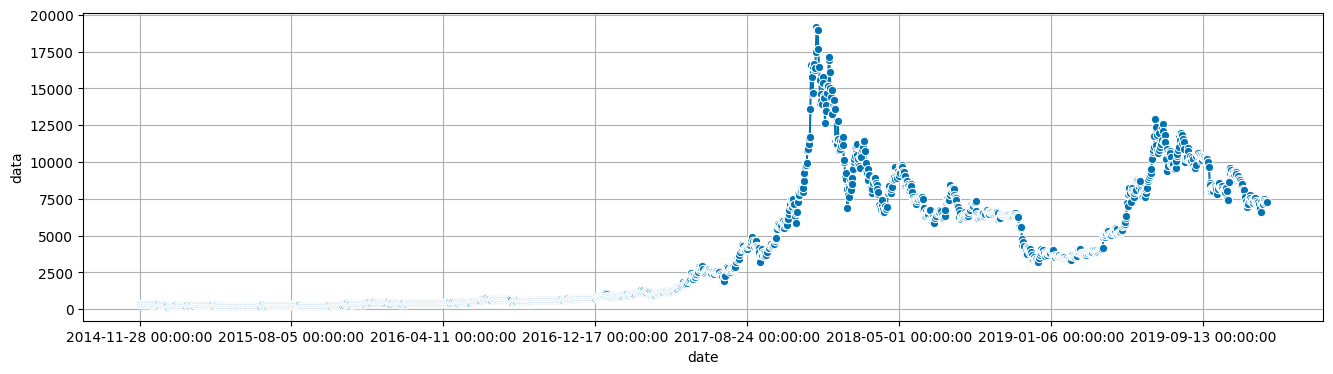

In [26]:
from sktime.utils.plotting import plot_series
_ = plot_series(df_series, x_label='date', y_label='data')
plt.grid()